In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from pythainlp.tokenize import word_tokenize
import emoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from visualize import top_feats_all, plot_top_feats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df = df.drop(df.columns[0], axis=1)
df = df.loc[df['target']=='pos']
df

comments target
0    ดีค่ะ วิทยากรมีความรู้ดีมาก พูดเข้าใจ การสอนมี...    pos
1    ชอบมาก เหมาะสมหรับผู้ที่มีผู้ฐานเรื่องการตลาด ...    pos
2    คอร์สเนื้อหาแน่น และผู้สอนก็สอนได้ละเอียด มีขั...    pos
3    คอร์สนี้ช่วยให้หลักการและกรอบในการดำเนินงานด้า...    pos
4        สอนแบบมี Logic และ วิธีการที่ชัดเจน ชอบมากค่ะ    pos
..                                                 ...    ...
884  เหมาะสมกับทั้งคนที่ยังไม่มีพื้นฐาน และคนที่อยา...    pos
885  อันนี้รีวิว หลังจากดูจบแล้วครับ\nเกรินก่อน ผมเ...    pos
886  อ.บอย สอนได้ละเอียดมากครับ\nแต่ถ้าเอาไปเขียนเอ...    pos
887  สอนได้ละเอียดกระชับและชัดเจน เข้าใจได้ง่ายครับ...    pos
888                                      ดีสุดๆเลยครับ    pos

[789 rows x 2 columns]

In [3]:
#from pythainlp.corpus import thai_stopwords
#thaistopwords = list(thai_stopwords())
stopwords = ['ที่','และ','เป็น','มี','ให้','ครับ','ค่ะ','ใน','ได้','การ','มา','ๆ','นี้','ไป','จะ','เลย']

In [4]:
from pythainlp.util import normalize

def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    res = text.lower().strip() 
    res = replace_url(res)
    res = [word for word in word_tokenize(res) if word not in stopwords and not re.search(pattern=r"\s+", string=word)]
    res = ungroup_emoji(res)
    return res

In [5]:
df['processed'] = df.comments.map(lambda x: '|'.join(process_text(x)))

In [6]:
#lr = LogisticRegression()

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20,max_df=0.5, sublinear_tf=True)
tfidf_fit = tfidf.fit(df['comments'])
text_df = tfidf_fit.transform(df['comments'])

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
text = text_df.toarray()
final_df = pd.DataFrame(data = text, columns=tfidf.get_feature_names())

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
final_df

data       กับ  การทำงาน    การสอน        ก็      ก่อน       ของ  ขอบคุณ  \
0     0.0  0.000000       0.0  0.173904  0.000000  0.000000  0.000000     0.0   
1     0.0  0.000000       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
2     0.0  0.000000       0.0  0.429126  0.350553  0.000000  0.000000     0.0   
3     0.0  0.000000       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
4     0.0  0.000000       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
..    ...       ...       ...       ...       ...       ...       ...     ...   
784   0.0  0.281091       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
785   0.0  0.141718       0.0  0.000000  0.259334  0.173046  0.231053     0.0   
786   0.0  0.000000       0.0  0.000000  0.000000  0.000000  0.000000     0.0   
787   0.0  0.000000       0.0  0.457386  0.000000  0.000000  0.000000     0.0   
788   0.0  0.000000       0.0  0.000000  0.000000  0.000000  0.000000     0.0   

     ขึ้น  ข้อมูล  ...  เห็น  เห็นภาพ       แต่  แนะนำ       แบบ      แล้ว  \
0     0.0     0.0  ...   0.0      0.0  0.245093    0.0  0.151616  0.000000   
1     0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   
2     0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   
3     0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   
4     0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.532114  0.000000   
..    ...     ...  ...   ...      ...       ...    ...       ...       ...   
784   0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   
785   0.0     0.0  ...   0.0      0.0  0.125917    0.0  0.000000  0.344322   
786   0.0     0.0  ...   0.0      0.0  0.285060    0.0  0.000000  0.000000   
787   0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   
788   0.0     0.0  ...   0.0      0.0  0.000000    0.0  0.000000  0.000000   

          ใช้      ใหม่  ได้ดี       ไม่  
0    0.122712  0.000000    0.0  0.220578  
1    0.000000  0.275181    0.0  0.174365  
2    0.000000  0.000000    0.0  0.000000  
3    0.000000  0.000000    0.0  0.000000  
4    0.000000  0.000000    0.0  0.000000  
..        ...       ...    ...       ...  
784  0.000000  0.000000    0.0  0.224770  
785  0.132304  0.000000    0.0  0.000000  
786  0.000000  0.000000    0.0  0.000000  
787  0.000000  0.000000    0.0  0.000000  
788  0.000000  0.000000    0.0  0.000000  

[789 rows x 104 columns]

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10), KMeans(n_clusters=11)]
[54.90528467112084, 34.755551858028326, 19.296965006403227, 14.789846181775108, 11.77482115266867, 9.215301337069775, 7.244681034785476, 6.398700914999493, 5.709041836094055, 5.1488625169212945, 4.545532502127909]


<function matplotlib.pyplot.show(close=None, block=None)>

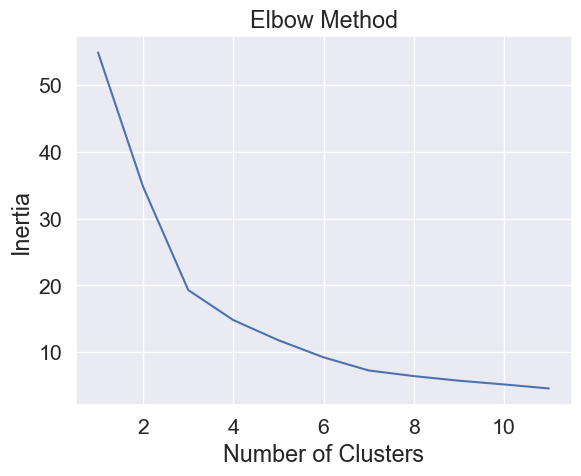

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(final_df)

number_clusters = range(1,12)

kmeans = []
for i in number_clusters:
    kmeans.append(KMeans(n_clusters=i, max_iter = 300))
print(kmeans)
inertia =[]
for i in number_clusters:
    model = KMeans(n_clusters=i,max_iter=300,n_init=10,random_state=0)
    model.fit(Y_sklearn)
    inertia.append(model.inertia_)
print(inertia)

plt.plot(number_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show

In [31]:
from imblearn.pipeline import make_pipeline
k = 9
km = KMeans(n_clusters=k, init='k-means++', max_iter=100,random_state=0)
pos_kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100,random_state=0).fit(final_df)
pipeline = make_pipeline(tfidf,km)

In [32]:
pos_k = pipeline.fit(df.comments)

In [33]:
centroids = pos_kmeans.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = tfidf.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: จริง นำไปใช้ สามารถ เข้าใจง่าย การทำงาน งาน ของ เนื้อหา มาก สอน
Cluster 1: มากขึ้น เข้าใจ อยาก ทำ ทำให้ ต้อง กับ ของ ตัวอย่าง สามารถ
Cluster 2: ดี สอน สอน ดี เข้าใจง่าย ละเอียด คอร์ส มาก เรียน แต่ เยอะ
Cluster 3: มาก ชอบ เยอะ ความรู้ คอร์ส เข้าใจ ขอบคุณ สำหรับ เนื้อหา แต่
Cluster 4: ชัดเจน เห็นภาพ อธิบาย เข้าใจง่าย คอร์ส ดี ผู้สอน ยกตัวอย่าง เข้าใจ เนื้อหา
Cluster 5: สอน เข้าใจง่าย สอน เข้าใจง่าย เข้าใจง่าย มาก ขอบคุณ ง่าย ทำ มาก ด้วย ลอง
Cluster 6: ไม่ พื้นฐาน เรียน คอร์ส ว่า แต่ คน แล้ว เข้าใจ ก็
Cluster 7: ดีมาก สอน ดีมาก สอน ความรู้ การทำงาน คอร์ส อธิบาย ด้วย เข้าใจ ทำ
Cluster 8: เข้าใจง่าย เข้าใจง่าย มาก มาก อธิบาย ได้ดี ละเอียด เรียน ดีมาก เนื้อหา คอร์ส


/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
df['Kmean Clus Label'] = pos_kmeans.labels_

In [35]:
df['Kmean Clus Label'].value_counts()

1    270
6    138
3     84
7     65
2     64
0     47
4     46
8     44
5     31
Name: Kmean Clus Label, dtype: int64

In [36]:
word_cluster_pred=pos_k.predict(df.comments)

In [37]:
for i in df['comments'].loc[df['Kmean Clus Label']== 0]:
    print(i)

เป็นการเล่า overall เรื่อง social listening  ที่เป็นควรรู้ก่อนทำจริง
5 ทำให้เข้าใจการทำงานของ chatbot มากขึ้น เพื่อนำไปใช้ในการทำงานจริงได้
จากไม่รู้จริง ตอนนี้มี line bot แล้ว จบคอร์สทำได้จริง
เข้าใจง่าย นำไปใช้ต่อได้จริง
ข้อความมีผิดอยู่บ้าง แต่เป็นในแง่ตัวสะกดต่าง ๆ ยังไม่กระทบต่อเนื้อหาหลัก
สามารถapply สิ่งที่เรียนไปใช้ได้จริงเกิดประโยชน์มากในการช่วยวิเคราะห์ข้อมูลปริมาณมากๆ
สอนการใช้งานโปรแกรมได้ครอบคลุมมากค่ะ นำไปใช้ได้จริง
สั้น กระชับ ดีมาก คาดว่าสามารถนำไปทำแดชบอร์ดได้จริง
อาจารย์ช่วยเปิดมุมมองการนำข้อมูลมาเป็นส่วนหนึ่งของการออกแบบผลิตภัณฑ์ รวมถึงแชร์ประสบการณ์จริง ทำให้เห็นภาพของการทำงานร่วมกันหลายฝ่าย ข้อดีและข้อควรระวังของการใช้ข้อมูล
ได้ทราบแนวคิดการนำ data ไปใช้วิเคราะห์ในสถานการณ์จริง
อยากดูตัวอย่างการทำงานจริงของ data science แล้ว tool ที่ใช้
กับบริษัทในไทย หรือ simulate company มา
มีเนื้อหาที่สามารถนำไปใช้ได้จริง !!!
เป็นการแนะนำที่เข้าใจมากๆและสามารถนำไปใช้ได้จริงทั้งธุรกิจและใช้ดำเนินการแก้ไขปัญหาได้จริง
ทำให้เห็นความสำคัญของ Cybersecurity ซึ่งเป็นเรื่องใกล้ตัว ที่นำไ

In [ ]:
current_labels = [0, 1, 2, 3, 4]
desired_labels = ['ดี', 'ไม่_แต่', 'เข้าใจง่าย', 'ดีมาก', 'เข้าใจมากขึ้น']
# create a dictionary for your corresponding values
map_dict = dict(zip(current_labels, desired_labels))

# map the desired values back to the dataframe
# note this will replace the original values
df['Kmean Clus Label'] = df['Kmean Clus Label'].map(map_dict)


In [38]:
label = list(df['Kmean Clus Label'].unique())
label

[6, 3, 4, 1, 0, 2, 8, 5, 7]

6


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


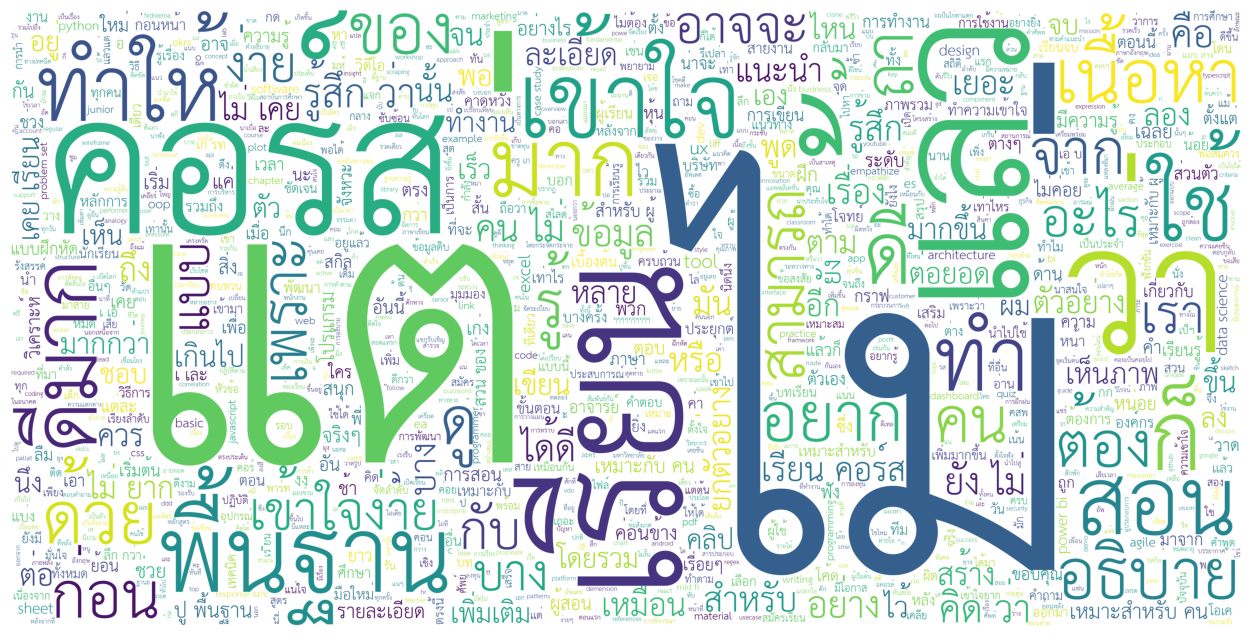

3


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


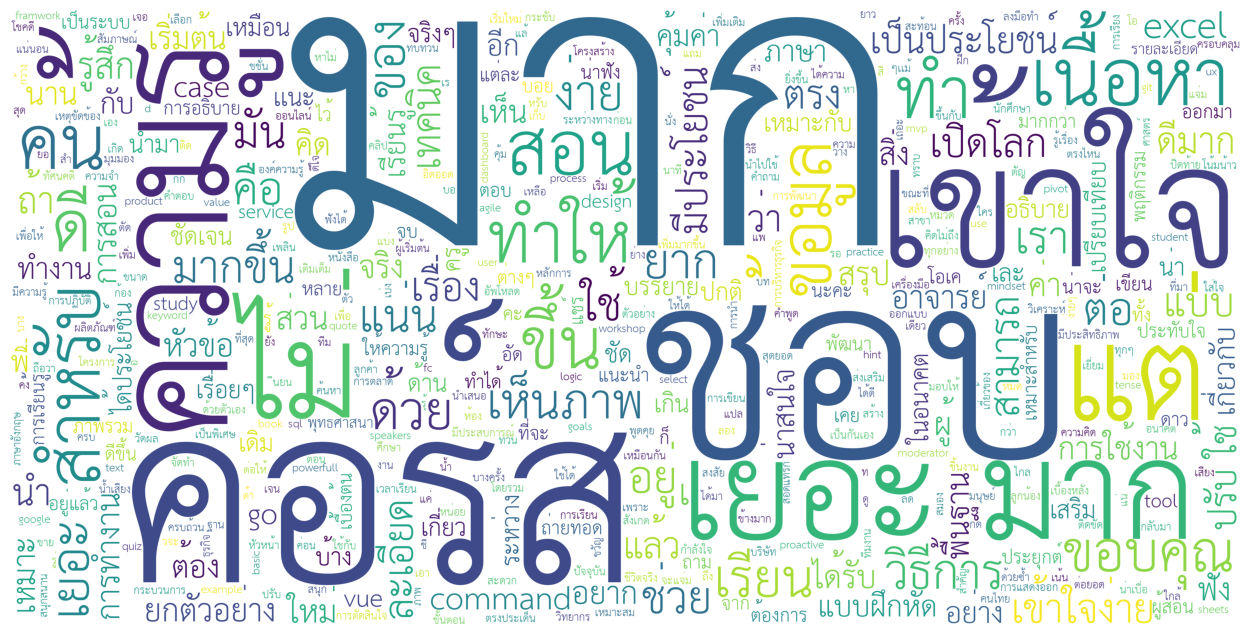

4


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


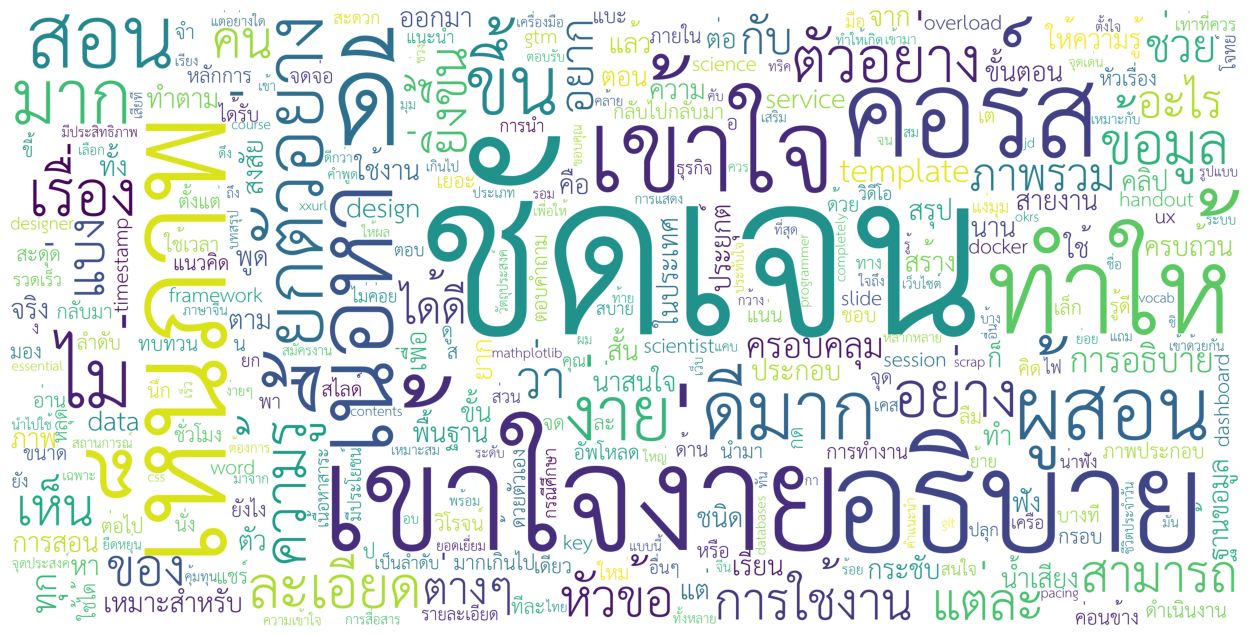

1


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


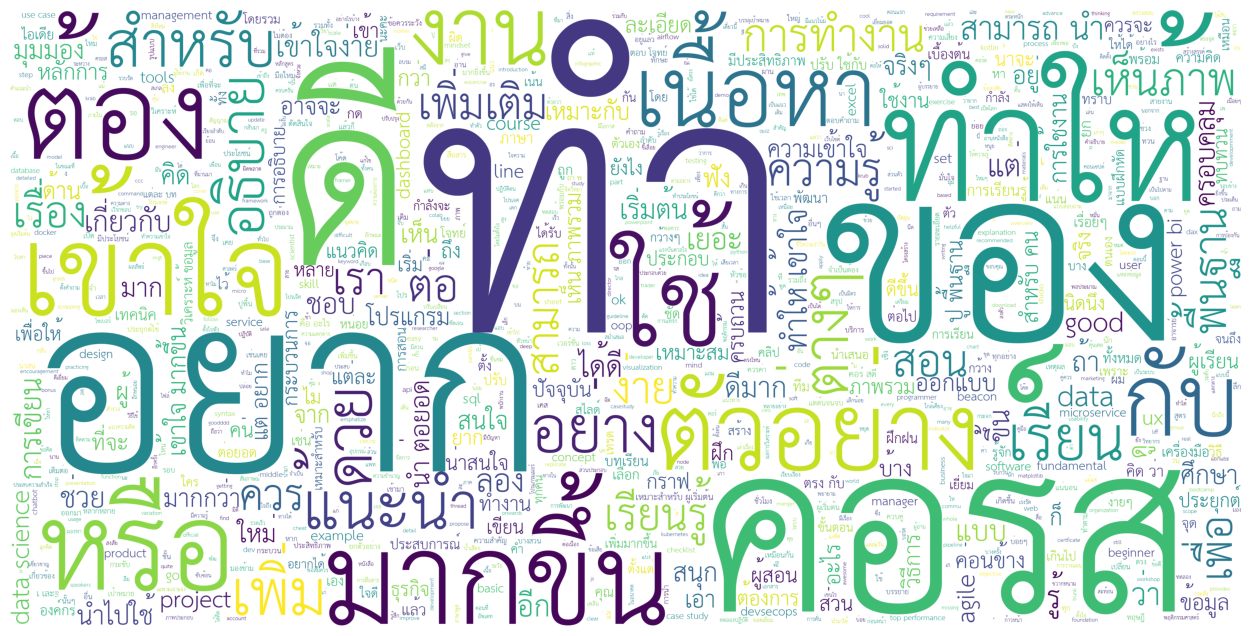

0


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


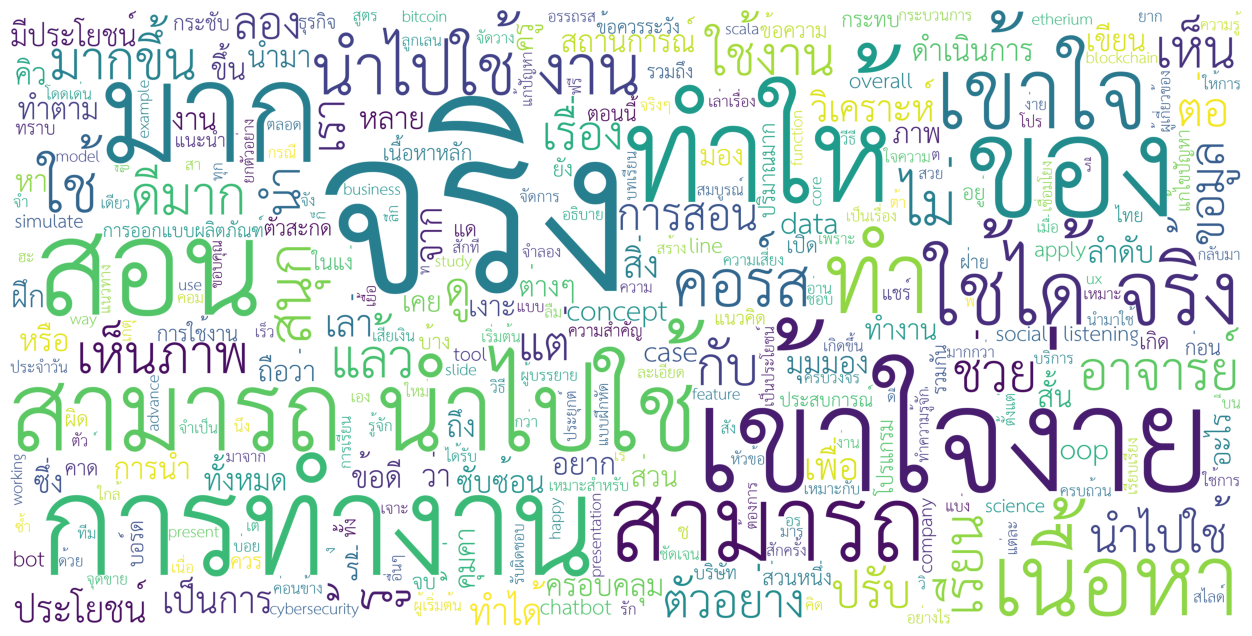

2


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


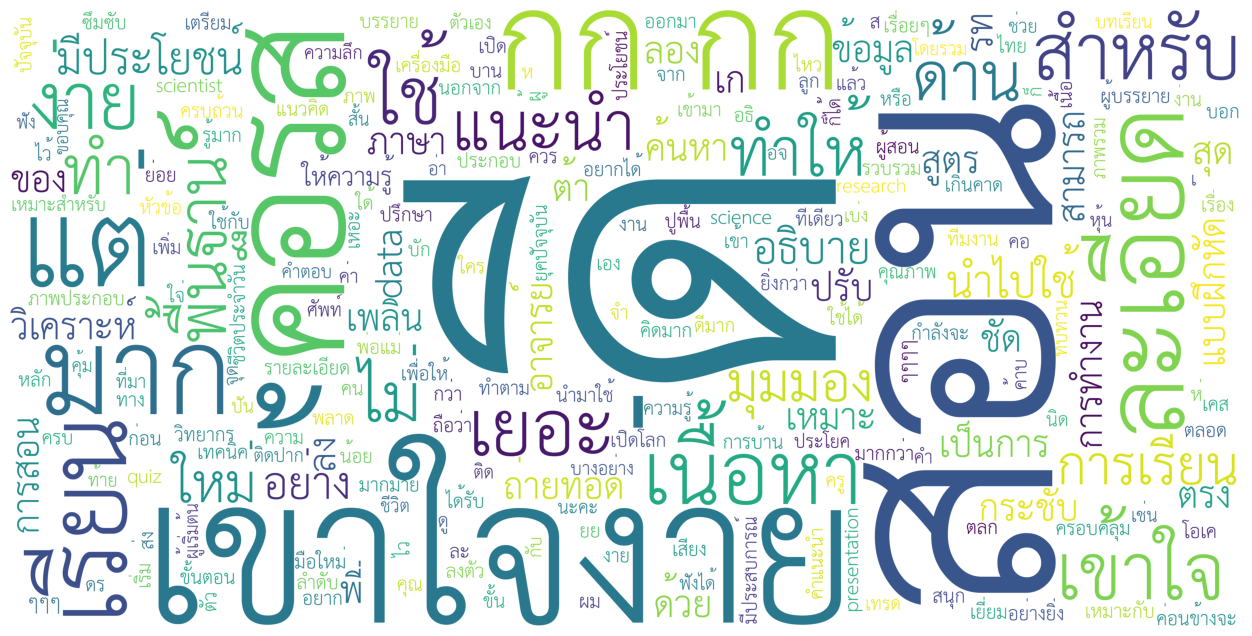

8


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


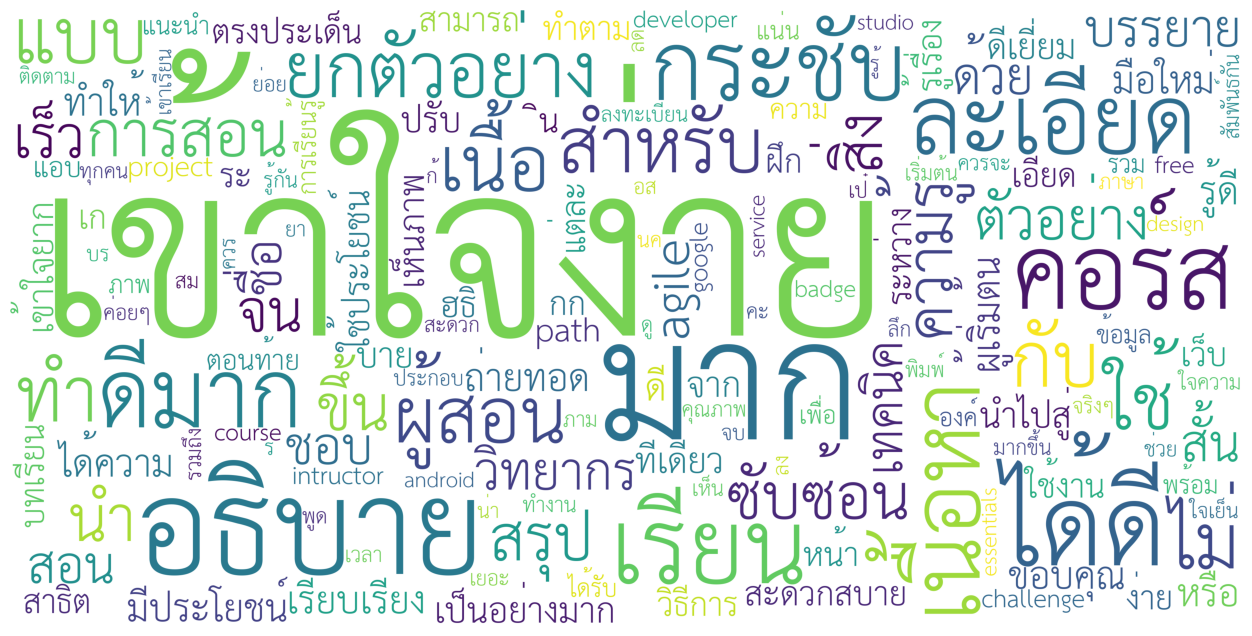

5


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


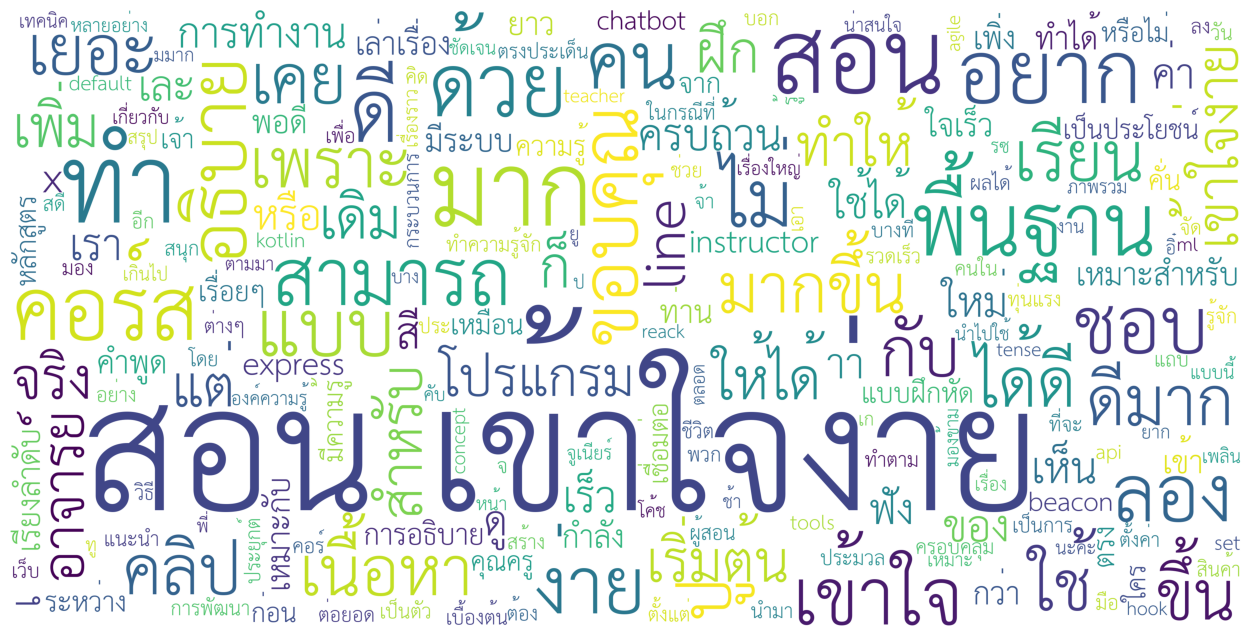

7


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_8555/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


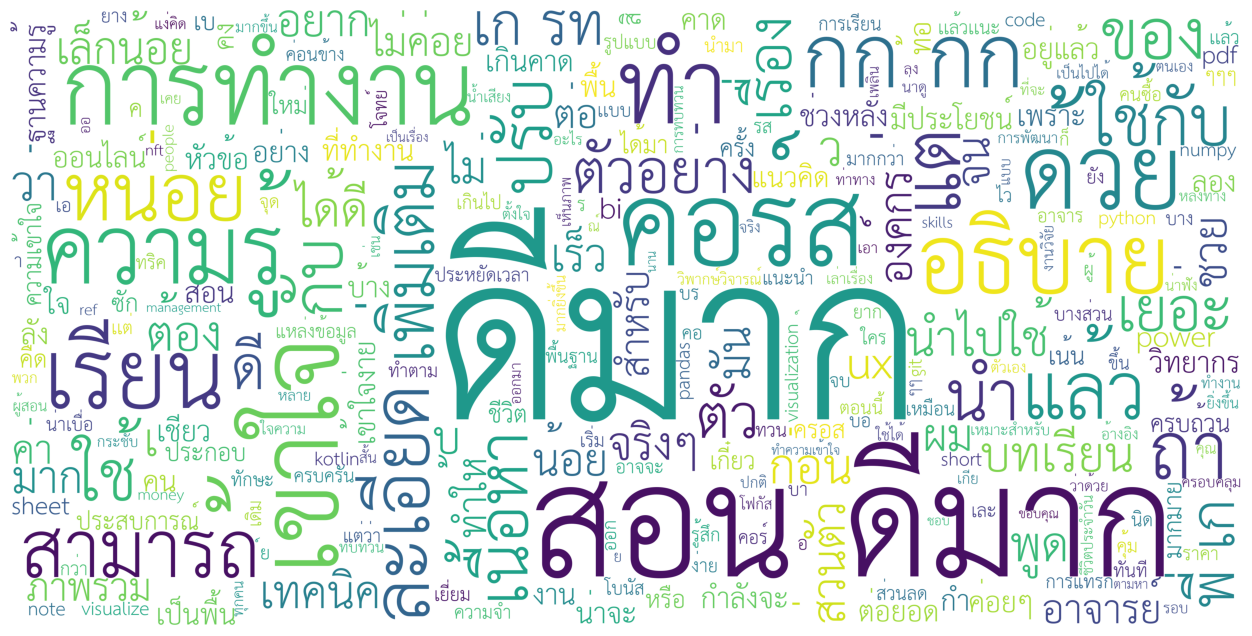

In [39]:
for i in label:
    print(i)
    data = df[df['Kmean Clus Label'] == i]
    word_all = " ".join(text for text in data['processed'].str.replace('|',' '))
    reg = r"[ก-๙a-zA-Z']+"
    fp = 'thsarabunnew-webfont.ttf'
    wordcloud = WordCloud(background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(word_all)
    plt.figure(figsize = (16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [40]:
sample = ['สอนดีมากๆค่ะ','อยากให้สอนได้ละเอียดมากกว่านี้','สอนค่อนข้างดี แต่อยากได้ตัวอย่าง','ไม่สนุกเลย','อยากให้เพิ่มเนื้อหา','สอนละเอียดมากครับ']
pos_k.predict(sample)

array([3, 1, 2, 6, 1, 0], dtype=int32)

In [41]:
import pickle
pickle.dump(pos_k, open('pos_clustering.pkl', 'wb'))